In [179]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from collections import defaultdict
import seaborn as sns

In [180]:
df = pd.read_csv(r'./owid-2022-clean.csv')

# Feature Selection

1. Remove irrelevant fields as in instructions
- location
- date 
- total_deaths_per_million 
- total_cases_per_million
- population
- tests_units

In [181]:
# Drop irrelevant fields
print(df.columns.shape)
df.drop(["location", "date", "total_deaths_per_million", "total_cases_per_million", "population", "tests_units"], axis=1, inplace=True)
print(df.columns.shape)

(31,)
(25,)


Then check which features have too many missing values

In [182]:
for col_name, col_data in df.iteritems():
    num_null = col_data.isnull().sum()
    if num_null >= len(df)//2:
        print(f"{col_name}: {num_null}/{len(df)}")


people_vaccinated_per_hundred: 734/1323
people_fully_vaccinated_per_hundred: 717/1323
total_boosters_per_hundred: 856/1323
handwashing_facilities: 672/1323


We can see that there are 4 features that half of them are missing values. However, these features may be a good indicator for prediction; thus, we need to look into each continent for more insights

In [183]:
df_group_iso = df.groupby(["iso_code"])
df_group_cont = df.groupby(["continent"])

null_feat = defaultdict(int)
for cont, data in df_group_cont:
    print(f"{cont}:")
    for cols_name, col_data in data.iteritems():
        num_null = col_data.isnull().sum()
        if num_null >= len(col_data)//2:
            null_feat[cols_name] += 1
            print(f"{cols_name:<50}:\t {num_null}/{len(data)}")
            

    print()




Africa:
people_vaccinated_per_hundred                     :	 298/378
people_fully_vaccinated_per_hundred               :	 300/378
total_boosters_per_hundred                        :	 352/378

Asia:
total_boosters_per_hundred                        :	 191/329

Europe:
handwashing_facilities                            :	 273/294

North America:
people_vaccinated_per_hundred                     :	 104/175
people_fully_vaccinated_per_hundred               :	 105/175
total_boosters_per_hundred                        :	 123/175
extreme_poverty                                   :	 98/175
male_smokers                                      :	 91/175

Oceania:
new_tests_smoothed_per_thousand                   :	 42/63
positive_rate                                     :	 56/63
tests_per_case                                    :	 56/63
people_vaccinated_per_hundred                     :	 42/63
people_fully_vaccinated_per_hundred               :	 42/63
total_boosters_per_hundred                     

In [184]:
df.columns

Index(['iso_code', 'continent', 'new_cases_per_million',
       'new_deaths_per_million', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

Next we will look into the correlation between variables with respect to continent to spot dependent features

First we inpect "age" group 

In [185]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [186]:
# age_cols = ["continent", 
#             "median_age", 
#             "aged_65_older", 
#             "aged_70_older", 
#             "life_expectancy"]
# df_age = df.loc[:, age_cols]
# sns.pairplot(df_age, hue="continent", corner=True)

In the graph above, there is a high correlation between ```aged_65_older``` and ```aged_70_older```, thus we can remove ```aged_70_older``` from prediction model


In [187]:
df["aged_70_older"].corr(df["aged_65_older"])

0.9946122663675626

In [188]:
df.drop(["aged_70_older"], inplace=True, axis=1)

Next, we inspect booster group as many booster features have too many missing values as shown above

In [189]:
# boost_cols = [
#     "continent", 
#     "people_vaccinated_per_hundred", 
#     "people_fully_vaccinated_per_hundred", 
#     "total_boosters_per_hundred", 
#     "tests_per_case", 
#     "new_tests_smoothed_per_thousand"] 

# df_boost = df.loc[:, boost_cols]
# sns.pairplot(df_boost, hue="continent", corner=True)

In [190]:
df["people_fully_vaccinated_per_hundred"].corr(df["total_boosters_per_hundred"])

0.794440276907046

In [191]:
df["people_fully_vaccinated_per_hundred"].corr(df["people_vaccinated_per_hundred"])



0.9712407852959766

In the graph above, there is a high correlation between ```people_vaccinated_per_hundred```, ```people_fully_vaccinated_per_hundred```, and ```total_boosters_per_hundred```. Also these 2 removed features are also in the list of features with many missing values. Thus we can remove ```people_vaccinated_per_hundred``` and ```total_boosters_per_hundred``` from prediction model.

In [192]:
df.drop(["people_vaccinated_per_hundred", "total_boosters_per_hundred"], inplace=True, axis=1)

Next, we inspect standard of living group to see if we can remove handwahsing facilities feature as it has many missing values in several continents

In [193]:
df.columns

Index(['iso_code', 'continent', 'new_cases_per_million',
       'new_deaths_per_million', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case',
       'people_fully_vaccinated_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita',
       'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'handwashing_facilities',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index'],
      dtype='object')

In [194]:
# live_cols = [
#     "continent", 
#     "gdp_per_capita", 
#     "extreme_poverty", 
#     "handwashing_facilities", 
#     "hospital_beds_per_thousand", 
#     "human_development_index"] 

# df_live = df.loc[:, live_cols]
# sns.pairplot(df_live, hue="continent", corner=True)

In [195]:
temp_cor = df["handwashing_facilities"].corr(df["human_development_index"])
print(f"corr between handwashing_facilities and human_development_index: {temp_cor:.4f}")

corr between handwashing_facilities and human_development_index: 0.8357


we can see that there is a high correlation (around 0.83) between ```handwashing_facilities``` and ```human_development_index```

Moreover, ```handwashing_facilities``` has many missing values and ```human_development_index``` is a more holistic feature, thus we can remove ```handwashing_facilities``` from prediction model.


In [196]:
df.drop(["handwashing_facilities"], inplace=True, axis=1)

In [197]:
df.columns

Index(['iso_code', 'continent', 'new_cases_per_million',
       'new_deaths_per_million', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case',
       'people_fully_vaccinated_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita',
       'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

Health Category

In [198]:
# health_cols = [
#     "continent", 
#     "cardiovasc_death_rate", 
#     "diabetes_prevalence", 
#     "female_smokers", 
#     "male_smokers", 
#     "life_expectancy", 
#     "human_development_index"] 

# df_health = df.loc[:, health_cols]
# sns.pairplot(df_health, hue="continent", corner=True)

In [199]:
df["human_development_index"].corr(df["life_expectancy"])

0.9120847433498297

As life expectancy is one of the criteria in Human Development Index measurement, the graph shows a clear relationship between them. Therefore, it would be sensible to drop the `life_expectancy` feature

In [200]:
df.drop(["life_expectancy"], inplace=True, axis=1)

In [201]:
df.shape

(1323, 20)

# Filling missing data

In each continent, countries differ in many aspects such as population, human development index, GDP, and so on. For example China is a great outliner in Asia and most of countries with many missing values is somewhat developing countries with these aspects are in big difference compared to China. 

Therefore, it would be better to fill in the missing value with the median of that feature in a continent, instead of mean if that country has the whole feature values missing.

If that country's feature has at least one value then we can take the mean or if number of values is more than 4 then we just do interpolation.

Before filling in the value, notice hat in Oceania, there are some features (`new_tests_smoothed_per_thousand`, `positive_rate`, `tests_per_case`, `total_boosters_per_hundred`, `handwashing_facilities`, and so on) exist in only one or two countries (Australia). For that reason, taking the median or mean in that continent is not a good idea.

Despite that lack of data, we still fill in these countries in Oceania with median and carefully observe their result in the later step

In [203]:
applied_cols = list(df.columns)
df_group_iso = df.groupby(["iso_code"])
df_group_cont = df.groupby(["continent"])

for col_name, col_data in df.iteritems():
    if col_name == "iso_code" or col_name=="continent":
        continue
    df[col_name] = df_group_iso[col_name].apply(lambda x: x.fillna(x.mean()))
    df[col_name] = df_group_cont[col_name].apply(lambda x: x.fillna(x.median()))



Now all the regressors values is filled in

In [208]:
df.isna().sum()

iso_code                               0
continent                              0
new_cases_per_million                  0
new_deaths_per_million                 0
new_tests_smoothed_per_thousand        0
positive_rate                          0
tests_per_case                         0
people_fully_vaccinated_per_hundred    0
stringency_index                       0
population_density                     0
median_age                             0
aged_65_older                          0
gdp_per_capita                         0
extreme_poverty                        0
cardiovasc_death_rate                  0
diabetes_prevalence                    0
female_smokers                         0
male_smokers                           0
hospital_beds_per_thousand             0
human_development_index                0
dtype: int64

Next, there are entries with 0 values in 2 prediction columns (`new_cases_per_million` and `new_death_per_million`). 

If all 7 days values are 0 then we can drop that country or replace with median of the continent, else if we have at least 1 day with value then replace with mean value of other days

In [214]:
df_group_cont_med = df_group_cont.median()
for col_name, col_data in df_group_iso:    
    for col in col_data:
        if (col_data[col] == 0).all():
            target = df.loc[df["iso_code"] == col_name]
            df.loc[df["iso_code"] == col_name, col] = target[col].replace(0, df_group_cont_med.at[target["continent"].iloc[0], col])

In [210]:
df.to_csv("./test.csv")

Next change categorical fields (`continent`) into boolean variable

In [215]:
indicator_cols = pd.get_dummies(df[["continent"]])
df = pd.concat([df, indicator_cols], axis=1)
df.drop(["continent"], axis=1, inplace=True)

# Prediction

In [222]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

array([[<AxesSubplot:title={'center':'new_cases_per_million'}>,
        <AxesSubplot:title={'center':'new_deaths_per_million'}>,
        <AxesSubplot:title={'center':'new_tests_smoothed_per_thousand'}>,
        <AxesSubplot:title={'center':'positive_rate'}>,
        <AxesSubplot:title={'center':'tests_per_case'}>],
       [<AxesSubplot:title={'center':'people_fully_vaccinated_per_hundred'}>,
        <AxesSubplot:title={'center':'stringency_index'}>,
        <AxesSubplot:title={'center':'population_density'}>,
        <AxesSubplot:title={'center':'median_age'}>,
        <AxesSubplot:title={'center':'aged_65_older'}>],
       [<AxesSubplot:title={'center':'gdp_per_capita'}>,
        <AxesSubplot:title={'center':'extreme_poverty'}>,
        <AxesSubplot:title={'center':'cardiovasc_death_rate'}>,
        <AxesSubplot:title={'center':'diabetes_prevalence'}>,
        <AxesSubplot:title={'center':'female_smokers'}>],
       [<AxesSubplot:title={'center':'male_smokers'}>,
        <AxesSubplot:

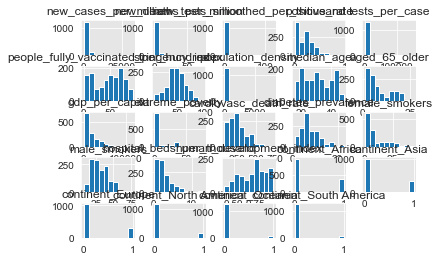

In [219]:
df.hist()

As some features do not follow normal distribution, therefore, we will use min max scaler instead of standard scaler

In [224]:
X = df.drop(['iso_code', 'new_cases_per_million','new_deaths_per_million'], inplace = False, axis = 1).to_numpy()
y = df[['new_cases_per_million','new_deaths_per_million']].to_numpy()

In [225]:
X_scaled = MinMaxScaler().fit_transform(X)